In [4]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import math

### Chapter 1 — Understanding the World Through Data
In this notebook we will explore a small, synthetic dataset with following metrics: daily rainfall (mm), reservoir inflow (cumecs), hydropower generation (MWh), 
and number of equipment outages. Each section is a small, focused cell so you can run them step-by-step.


### Creating synthetic dataset

In [ ]:
np.random.seed(42)
days = pd.date_range(end=pd.Timestamp.today(), periods=90)

# simulate rainfall: many small values, a few heavy storms (right skew)
rain_base = np.random.gamma(shape=1.5, scale=8, size=90)  # gamma for right-skew
# add occasional heavy events
heavy_event_idx = np.random.choice(range(90), size=4, replace=False)
rain_base[heavy_event_idx] += np.random.uniform(50, 120, size=4)

# reservoir inflow roughly correlated with recent rainfall with some lagged noise
inflow = (0.8 * pd.Series(rain_base).rolling(3, min_periods=1).mean().values) + np.random.normal(5, 8, 90)
inflow = np.clip(inflow, a_min=0, a_max=None)  # no negative inflows

# generation roughly proportional to inflow but with operational caps and some variation
generation = np.minimum(200 + 2.5 * inflow + np.random.normal(0, 10, 90), 500)

# outages: small integer counts, sometimes 0, sometimes >0
outages = np.random.poisson(lam=0.6, size=90)
outages[np.random.choice(range(90), size=3, replace=False)] += np.random.randint(2,5,size=3)  # a few spikes

df = pd.DataFrame({
    "date": days,
    "rainfall_mm": np.round(rain_base, 1),
    "inflow_cumecs": np.round(inflow, 2),
    "generation_MWh": np.round(generation, 1),
    "outages_count": outages
})

df = df.set_index("date")

df

,rainfall_mm,inflow_cumecs,generation_MWh,outages_count
date,,,,
2025-08-27 21:18:50.719243,14.3,18.83,236.0,1
2025-08-28 21:18:50.719243,8.2,8.14,211.7,1
2025-08-29 21:18:50.719243,7.5,14.55,244.3,1
2025-08-30 21:18:50.719243,7.5,6.71,223.1,1
2025-08-31 21:18:50.719243,30.7,16.14,217.8,0
...,...,...,...,...
2025-11-20 21:18:50.719243,1.2,14.72,253.7,1
2025-11-21 21:18:50.719243,11.0,0.00,182.7,1
2025-11-22 21:18:50.719243,11.8,12.84,233.5,0


##### Quick overview- 
- info() shows types and non-null counts
- describe() gives numeric summaries (count, mean, std, min, quartiles, max)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2025-08-27 21:18:50.719243 to 2025-11-24 21:18:50.719243
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rainfall_mm     90 non-null     float64
 1   inflow_cumecs   90 non-null     float64
 2   generation_MWh  90 non-null     float64
 3   outages_count   90 non-null     int32  
dtypes: float64(3), int32(1)
memory usage: 3.2 KB


In [12]:
df.describe()

,rainfall_mm,inflow_cumecs,generation_MWh,outages_count
count,90.000000,90.000000,90.000000,90.000000
mean,14.693333,17.674222,242.077778,0.700000
std,18.152579,12.394604,31.757398,0.953409
min,0.600000,0.000000,182.700000,0.000000
25%,5.825000,7.922500,215.650000,0.000000
50%,9.550000,15.590000,238.900000,0.000000
75%,16.900000,25.420000,258.550000,1.000000
max,101.500000,58.520000,338.400000,5.000000


#### Measures of Central Tendency

In [13]:
mean_rain = df['rainfall_mm'].mean()
median_rain = df['rainfall_mm'].median()


- Task 1 (Mean median for other columns?)

#### Measures of Dispersion - Range, SD, Variance, IQR, CV

In [16]:
def dispersion_metrics(series):
    rng = series.max() - series.min()
    var = series.var(ddof=1)
    sd = series.std(ddof=1)
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    cv = sd / series.mean() if series.mean() != 0 else np.nan
    return {"range": rng, "variance": var, "std_dev": sd, "q1": q1, "q3": q3, "iqr": iqr, "cv": cv}


In [28]:
disp_rain = dispersion_metrics(df['rainfall_mm'])
disp_rain


{'range': np.float64(100.9),
 'variance': np.float64(329.5161348314606),
 'std_dev': np.float64(18.152579288670264),
 'q1': np.float64(5.825),
 'q3': np.float64(16.9),
 'iqr': np.float64(11.075),
 'cv': np.float64(1.2354296249095005)}

- Task 2 (show the dispersion_metrics for inflow and generation)

#### Measures of Shape (Skewness and Kurtosis) 

In [21]:
skew_rain = df['rainfall_mm'].skew()
kurt_rain = df['rainfall_mm'].kurtosis()


In [24]:
skew_inflow = df['inflow_cumecs'].skew()
kurt_inflow = df['inflow_cumecs'].kurtosis()


In [26]:
display(Markdown(f"**Rainfall** — Skewness: {skew_rain:.3f}, Kurtosis: {kurt_rain:.3f}"))
display(Markdown(f"**Inflow** — Skewness: {skew_inflow:.3f}, Kurtosis: {kurt_inflow:.3f}"))


**Rainfall** — Skewness: 3.284, Kurtosis: 11.634

**Inflow** — Skewness: 0.814, Kurtosis: 0.761

- Task 3 - "What does the above metric tells?"

In [27]:
display(Markdown("Interpretation hints:\n- Positive skewness: long right tail (heavy storms)\n- Kurtosis > 0: heavier tails than a normal distribution (more extreme events)"))


Interpretation hints:
- Positive skewness: long right tail (heavy storms)
- Kurtosis > 0: heavier tails than a normal distribution (more extreme events)

#### Visuals: Rainfall distribution and boxplot

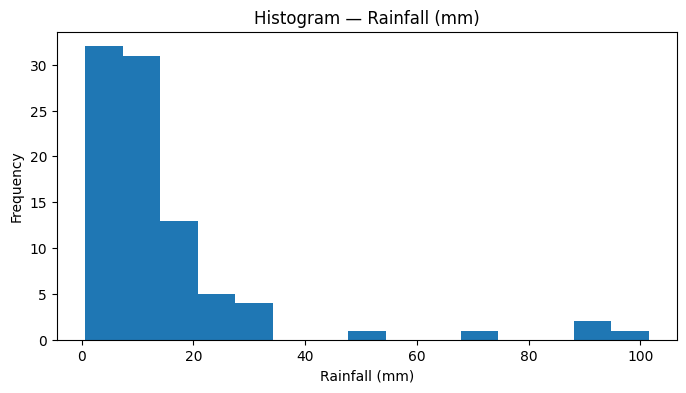

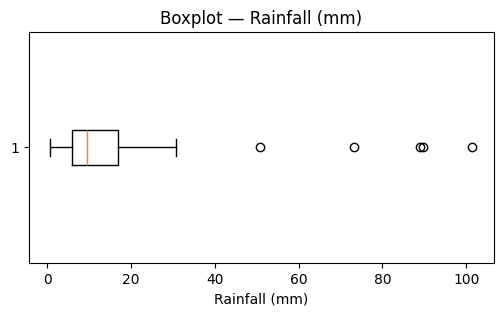

In [31]:
plt.figure(figsize=(8,4))
plt.hist(df['rainfall_mm'], bins=15)
plt.title("Histogram — Rainfall (mm)")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frequency")
plt.show()


plt.figure(figsize=(6,3))
plt.boxplot(df['rainfall_mm'], vert=False)
plt.title("Boxplot — Rainfall (mm)")
plt.xlabel("Rainfall (mm)")
plt.show()



#### Visuals — inflow time-series and generation scatter vs inflow (two separate plots)

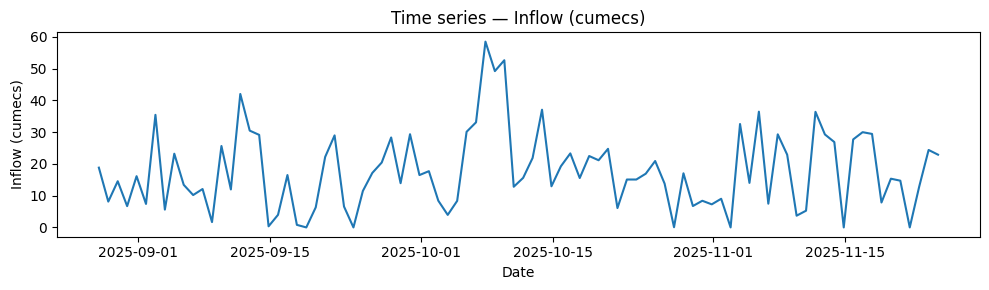

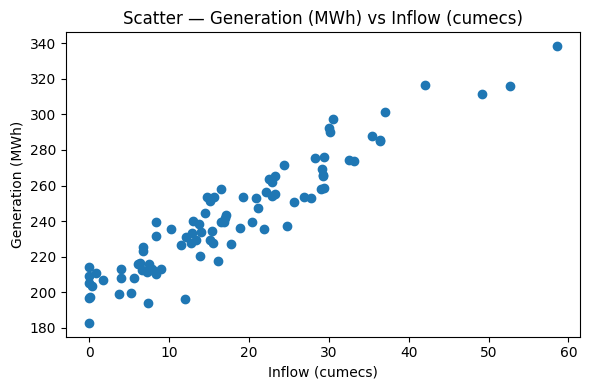

In [32]:
plt.figure(figsize=(10,3))
plt.plot(df.index, df['inflow_cumecs'])
plt.title("Time series — Inflow (cumecs)")
plt.ylabel("Inflow (cumecs)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df['inflow_cumecs'], df['generation_MWh'])
plt.title("Scatter — Generation (MWh) vs Inflow (cumecs)")
plt.xlabel("Inflow (cumecs)")
plt.ylabel("Generation (MWh)")
plt.tight_layout()
plt.show()


## Quick Exercise

### 1. Identify top rainfall days
- Inspect the dataset.
- Find the **top 3 days with the highest rainfall**.
---
### 2. Check inflow and generation on those days
- For each of the top rainfall days:
  - Review **inflow** values.
  - Review **generation** values.
- Assess whether the pattern **matches expectations** 
  (e.g., higher rainfall → higher inflow → potentially higher generation).
---
### 3. Outlier detection using IQR
- Compute the **Interquartile Range (IQR)** for the *generation* column:
  - IQR = Q3 - Q1
  - Outlier bounds:
    - Lower bound: Q1 - 1.5 × IQR
    - Upper bound: Q3 + 1.5 × IQR
- Identify the **days where generation lies outside these bounds**.


### Additional Practice Questions (Descriptive Analytics)

#### **Question 4 — Outage Patterns & Dispersion**
Using the `outages_count` column:
1. Compute the *interquartile range (IQR)*.  
2. Identify days where outages were unusually high (above Q3 + 1.5 × IQR).  
3. Briefly explain what operational factors might cause such spikes in a hydropower environment.

---

#### **Question 5 — Rainfall Skewness & Extreme Events**
Using the `rainfall_mm` column:
1. Calculate the **skewness** and **kurtosis**.  
2. Plot a histogram and mark the mean, median, and mode.  
3. Explain how right-skewness affects:  
   - flood preparedness  
   - spillway gate planning  
   - power generation decisions

---

#### **Question 6 — Relationship Between Inflow & Generation**
1. Compute the **Pearson correlation coefficient** between `inflow_cumecs` and `generation_MWh`.  
2. Plot a scatter plot and add a simple regression line.  
3. Using the slope of the line, interpret:  
   *“If inflow increases by 10 cumecs, how much does power generation change on average?”*

---


## ---hint

In [35]:
# ----------------------------------------------
# Question 1: Top 3 rainfall days and their inflow + generation
# ----------------------------------------------

# Get the top 3 rainfall days
top3_rain = df['rainfall_mm'].nlargest(3)

# Display those dates with full metrics
df.loc[top3_rain.index]


,rainfall_mm,inflow_cumecs,generation_MWh,outages_count
date,,,,
2025-10-07 21:18:50.719243,101.5,58.52,338.4,0
2025-09-11 21:18:50.719243,89.7,42.04,316.3,0
2025-10-05 21:18:50.719243,89.0,30.12,290.1,0


In [36]:
# ----------------------------------------------
# Question 2: IQR for Generation and Outlier Detection
# ----------------------------------------------

Q1 = df['generation_MWh'].quantile(0.25)
Q3 = df['generation_MWh'].quantile(0.75)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("IQR:", IQR)
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

# Find outliers
generation_outliers = df[(df['generation_MWh'] < lower_bound) | 
                         (df['generation_MWh'] > upper_bound)]

generation_outliers


IQR: 42.900000000000006
Lower Bound: 151.3
Upper Bound: 322.90000000000003


,rainfall_mm,inflow_cumecs,generation_MWh,outages_count
date,,,,
2025-10-07 21:18:50.719243,101.5,58.52,338.4,0


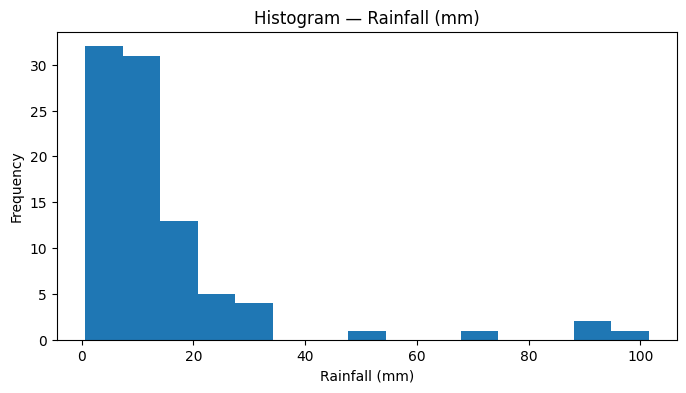

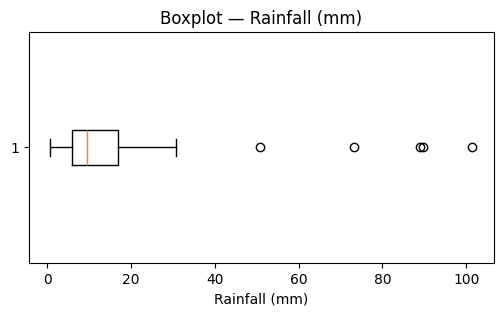

In [37]:
# ----------------------------------------------
# Question 3: Rainfall Histogram and Boxplot
# ----------------------------------------------

plt.figure(figsize=(8,4))
plt.hist(df['rainfall_mm'], bins=15)
plt.title("Histogram — Rainfall (mm)")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,3))
plt.boxplot(df['rainfall_mm'], vert=False)
plt.title("Boxplot — Rainfall (mm)")
plt.xlabel("Rainfall (mm)")
plt.show()


In [38]:
# ----------------------------------------------
# Question 4: IQR and Outliers for Outages
# ----------------------------------------------

Q1 = df['outages_count'].quantile(0.25)
Q3 = df['outages_count'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

print("Outages IQR:", IQR)
print("Upper Bound for Outliers:", upper_bound)

# Identify unusually high outage days
outage_outliers = df[df['outages_count'] > upper_bound]
outage_outliers


Outages IQR: 1.0
Upper Bound for Outliers: 2.5


,rainfall_mm,inflow_cumecs,generation_MWh,outages_count
date,,,,
2025-09-13 21:18:50.719243,7.0,29.15,269.4,5
2025-09-27 21:18:50.719243,4.6,28.33,275.3,5


Skewness: 3.2841185416136778
Kurtosis: 11.633553800445188


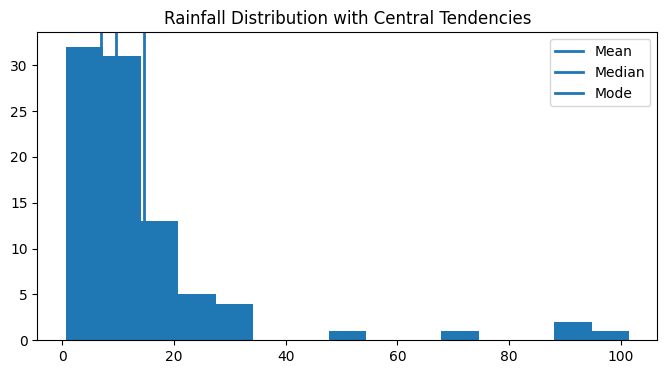

In [39]:
# ----------------------------------------------
# Question 5: Skewness, Kurtosis and Histogram
# ----------------------------------------------

skew = df['rainfall_mm'].skew()
kurt = df['rainfall_mm'].kurtosis()

print("Skewness:", skew)
print("Kurtosis:", kurt)

# Plot histogram with indicators
plt.figure(figsize=(8,4))
plt.hist(df['rainfall_mm'], bins=15)

mean_val = df['rainfall_mm'].mean()
median_val = df['rainfall_mm'].median()
mode_val = df['rainfall_mm'].mode()[0]

plt.axvline(mean_val, label="Mean", linewidth=2)
plt.axvline(median_val, label="Median", linewidth=2)
plt.axvline(mode_val, label="Mode", linewidth=2)

plt.title("Rainfall Distribution with Central Tendencies")
plt.legend()
plt.show()


Pearson Correlation: 0.9406236787450677
Regression Line: generation = 2.410 * inflow + 199.482


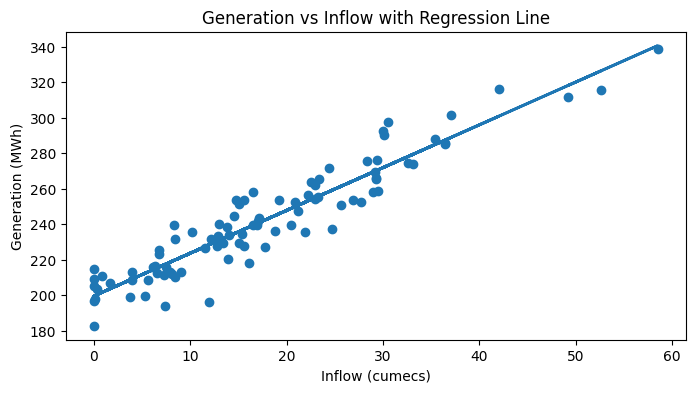

In [40]:
# ----------------------------------------------
# Question 6: Pearson Correlation + Regression Line
# ----------------------------------------------

# Compute correlation
corr = df['inflow_cumecs'].corr(df['generation_MWh'])
print("Pearson Correlation:", corr)

# Simple regression line
x = df['inflow_cumecs']
y = df['generation_MWh']

coef = np.polyfit(x, y, 1)   # linear fit
m, c = coef
print(f"Regression Line: generation = {m:.3f} * inflow + {c:.3f}")

# Plot scatter + line
plt.figure(figsize=(8,4))
plt.scatter(x, y)
plt.plot(x, m*x + c, linewidth=2)
plt.xlabel("Inflow (cumecs)")
plt.ylabel("Generation (MWh)")
plt.title("Generation vs Inflow with Regression Line")
plt.show()
